In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
import os
import pickle

In [3]:
with open('../data/gradcams/ternary/_DenseNet169_cams.np.npy', 'rb') as f:
    cams = np.load(f, allow_pickle=True)

with open('../data/gradcams/ternary/ternary_test_set.np.npy', 'rb') as f:
    images = np.load(f, allow_pickle=True)

In [4]:
hm = cams[13]
ex = images[13]

In [5]:
def _find_brain_contours(img2d):
	"""
	Computes a binary mask from a 2D slice of a brain image,
	separating the background from the foreground.
	Args:
		img2d (numpy.ndarray): the 2D slice.
	Returns:
		thr (numpy.ndarray): the computed binary mask.
	"""
	# findind brain contours
	gray = cv2.normalize(img2d, np.zeros((128, 128)), 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
	#plt.imshow(gray)

	# threshold
	thresh = cv2.threshold(gray, 11, 255, cv2.THRESH_BINARY)[1]

	# apply morphology to clean small spots
	kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
	morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
	kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
	morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
	kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
	morph = cv2.morphologyEx(morph, cv2.MORPH_ERODE, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)

	# get external contour
	contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	contours = contours[0] if len(contours) == 2 else contours[1]
	if contours:
		big_contour = max(contours, key=cv2.contourArea)

		# draw white filled contour on black background as mas
		contour = np.zeros_like(gray)
		cv2.drawContours(contour, [big_contour], 0, 255, -1)

		# blur dilate image
		blur = cv2.GaussianBlur(contour, (5,5), sigmaX=0, sigmaY=0, borderType = cv2.BORDER_DEFAULT)

		# stretch so that 255 -> 255 and 127.5 -> 0
		mask = skimage.exposure.rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255))

		# apply binarization
		thr = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
		thr[thr == 255.] = 1
		thr[thr == 0.] = 0
	else:
		thr = morph
		
	return thr

In [6]:
def _get_heatmap_mask(image, heatmap, threshold):
	"""
	Computes a 3D segmentation mask over the `image` brain shape,
	according to Grad-CAM `heatmap` and above a fixed `threshold`.
	Args:
		image (numpy.ndarray): the input 3D image.
		heatmap (numpy.ndarray): the Grad-CAM 3D heatmap.
		threshold (int): heat threshold above which draw the mask.
	Returns:
		mask (numpy.ndarray): the computed 3D segmentation mask.
	"""
	bg_mask = np.zeros(image.shape, dtype='uint8')
	heatmap_mask = np.zeros(image.shape, dtype='uint8')

	for z in range(image.shape[2]):
		thr = _find_brain_contours(image[:,:,z])
		# remove black padding
		#if np.unique(thr, return_counts=True)[1][0] >= 680:
		#	thr[thr == 1.] = 0

		bg_mask[:,:,z] = thr
	
	for y in range(image.shape[1]):
		thr = _find_brain_contours(image[:,y,:])
		# remove black padding
		#if np.unique(thr, return_counts=True)[1][0] >= 680:
		#	thr[thr == 1.] = 0

		bg_mask[:,y,:] = thr

	for x in range(image.shape[0]):
		thr = _find_brain_contours(image[x,:,:])
		# remove black padding
		#if np.unique(thr, return_counts=True)[1][0] >= 400:
		#	thr[thr == 1.] = 0
			
		bg_mask[x,:,:] = thr


	heatmap_mask[np.where((heatmap > threshold) & (bg_mask == 1))] = 1
    
	return heatmap_mask

In [7]:
def gradcam(image, sub, label, pred, threshold, heatmap, mask, alpha=128):
	"""
	Plots model input image, Grad-CAM heatmap and segmentation mask.
	Args:
		image (numpy.ndarray): the input 3D image.
		label (int): the input image label.
		pred (int): model prediction for input image.
		threshold (int): heat threshold above which draw the mask.
		heatmap (numpy.ndarray): the Grad-CAM 3D heatmap.
		mask (numpy.ndarray): the computed 3D segmentation mask.
		alpha (int): transparency channel. Between 0 and 255.
	Returns:
		None.
	"""
	if alpha >= 0 and alpha <= 255:
		heatmap_mask = np.zeros((image.shape[0], image.shape[1], image.shape[2], 4), dtype='uint8')
		heatmap_mask[mask == 1] = [255, 0, 0, alpha]
		image = image[:,int(image.shape[1] // 2),:]
		heatmap = heatmap[:,int(heatmap.shape[1] // 2),:]
		heatmap_mask = heatmap_mask[:,int(heatmap_mask.shape[2] / 2),:]
		fig, axs = plt.subplots(1, 3, figsize=(18, 6))
		norm_img = cv2.normalize(image, np.zeros((image.shape[1], image.shape[0])), 0, 1, cv2.NORM_MINMAX)
		im_shows = [
			axs[0].imshow(norm_img, cmap='gray', interpolation='bilinear', vmin = .0, vmax = 1.),
			axs[1].imshow(heatmap, cmap='jet', interpolation='bilinear', vmin = .0, vmax = 1.),
			axs[2].imshow(norm_img, cmap='gray', interpolation='bilinear', vmin = .0, vmax = 1.)
		]
		axs[2].imshow(heatmap_mask, interpolation='bilinear')
		axs[0].set_title('Image', fontsize=16)
		axs[1].set_title('Grad-CAM Heatmap', fontsize=16)
		axs[2].set_title('Mask - Threshold ' + str(threshold), fontsize=16)
		for i, ax in enumerate(axs):
			ax.axis('off')
			fig.colorbar(im_shows[i], ax=ax, ticks=np.linspace(0,1,6))
		#fig.tight_layout()
		fig.suptitle(f'{sub} - label: {label}, pred: {pred}', fontsize=20)
		plt.tight_layout() 
		#plt.subplots_adjust(hspace=0.8)
		plt.show()
	else:
		print('\n' + ''.join(['> ' for i in range(30)]))
		print('\nERROR: alpha channel \033[95m '+alpha+'\033[0m out of range [0,255].\n')
		print(''.join(['> ' for i in range(30)]) + '\n')

In [8]:
mask = _get_heatmap_mask(ex, hm, .6)

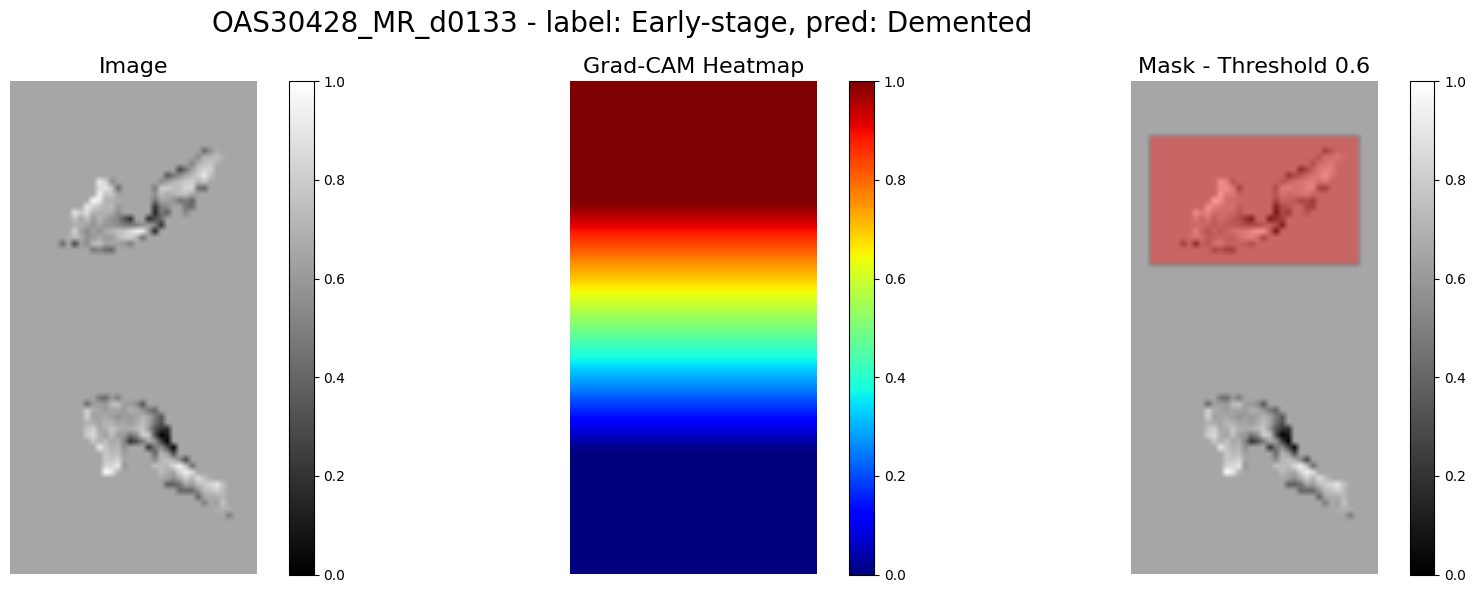

In [9]:
gradcam(ex, 'OAS30428_MR_d0133', 'Early-stage', 'Demented', .6, hm, mask, 100)

## Compute statistics

In [2]:
grad_paths = '../data/gradcams'

In [3]:
def foo(exp):
    output = {}
    lst = []

    #with open(os.path.join(grad_paths, exp, f'{exp}_test_set.np.npy'), 'rb') as f:
    #    images = np.load(f, allow_pickle=True)

    for j, name in enumerate(['_DenseNet121', '_DenseNet169', '_DenseNet201', '_DenseNet264']):
        output = {}
        count_low = 0
        count_upp = 0

        count_correct_class_low = 0
        count_wrong_class_low = 0

        count_correct_class_upp = 0
        count_wrong_class_upp = 0        
        
        with open(os.path.join(grad_paths, exp, f'{name}_cams.np.npy'), 'rb') as f:
            cams = np.load(f, allow_pickle=True)

        with open(os.path.join(grad_paths, exp, f'{name}_preds.pkl'), 'rb') as f:
            preds = pickle.load(f)

        for i, cam in enumerate(cams):
            upp_hm = cam[:40, cam.shape[1] // 2, :].sum()
            low_hm = cam[40:, cam.shape[1] // 2, :].sum()
            condition = preds['true'][i] == preds['pred'][i]

            if upp_hm >= low_hm:
                count_upp += 1

                if condition:
                    count_correct_class_upp += 1  
                else:
                    count_wrong_class_upp += 1
            elif low_hm >= upp_hm:
                count_low += 1

                if condition:
                    count_correct_class_low += 1  
                else:
                    count_wrong_class_low += 1
        
        print(name.split('_')[1])
        output['model'] = name.split('_')[1]
        output['left_hippo'] = count_upp
        output['right_hippo'] = count_low
        output['correctly classified (left hippo)'] = count_correct_class_upp
        output['correctly classified (right hippo)'] = count_correct_class_low
        output['missclassified (left hippo)'] = count_wrong_class_upp
        output['missclassified (right hippo)'] = count_wrong_class_low
        print(output)
        lst.append(output)

    return lst

In [4]:
foo('ternary')

DenseNet121
{'model': 'DenseNet121', 'left_hippo': 93, 'right_hippo': 46, 'correctly classified (left hippo)': 58, 'correctly classified (right hippo)': 32, 'missclassified (left hippo)': 35, 'missclassified (right hippo)': 14}
DenseNet169
{'model': 'DenseNet169', 'left_hippo': 78, 'right_hippo': 61, 'correctly classified (left hippo)': 55, 'correctly classified (right hippo)': 34, 'missclassified (left hippo)': 23, 'missclassified (right hippo)': 27}
DenseNet201
{'model': 'DenseNet201', 'left_hippo': 60, 'right_hippo': 79, 'correctly classified (left hippo)': 37, 'correctly classified (right hippo)': 58, 'missclassified (left hippo)': 23, 'missclassified (right hippo)': 21}
DenseNet264
{'model': 'DenseNet264', 'left_hippo': 66, 'right_hippo': 73, 'correctly classified (left hippo)': 40, 'correctly classified (right hippo)': 51, 'missclassified (left hippo)': 26, 'missclassified (right hippo)': 22}


[{'model': 'DenseNet121',
  'left_hippo': 93,
  'right_hippo': 46,
  'correctly classified (left hippo)': 58,
  'correctly classified (right hippo)': 32,
  'missclassified (left hippo)': 35,
  'missclassified (right hippo)': 14},
 {'model': 'DenseNet169',
  'left_hippo': 78,
  'right_hippo': 61,
  'correctly classified (left hippo)': 55,
  'correctly classified (right hippo)': 34,
  'missclassified (left hippo)': 23,
  'missclassified (right hippo)': 27},
 {'model': 'DenseNet201',
  'left_hippo': 60,
  'right_hippo': 79,
  'correctly classified (left hippo)': 37,
  'correctly classified (right hippo)': 58,
  'missclassified (left hippo)': 23,
  'missclassified (right hippo)': 21},
 {'model': 'DenseNet264',
  'left_hippo': 66,
  'right_hippo': 73,
  'correctly classified (left hippo)': 40,
  'correctly classified (right hippo)': 51,
  'missclassified (left hippo)': 26,
  'missclassified (right hippo)': 22}]